In [2]:
import graph
import numpy as np
import matplotlib.lines as mlines
from pylab import *
import matplotlib.pylab as plt
from matplotlib import pyplot
from matplotlib.pyplot import imshow
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.sparse as sp
import scipy.sparse.linalg as la
import scipy.spatial.distance
import scipy.io as sio
import process_data
from scipy.stats import poisson

Definition of Cayley Filter

In [3]:
def cayley(lamb, c, h, r):
    complex_value = 0.5 * c[0] * np.ones(len(lamb))
    for i in range(1, r+1):
        complex_value = complex_value + c[i]*((h*lamb -1j)**i)*((h*lamb + 1j)**(-i))
    return 2.0 * (complex_value.real)

In [4]:
h = 1.0

Summary

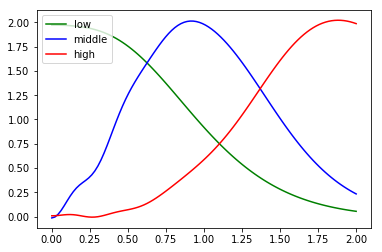

In [13]:
coefficients_low = array([ 0.762957  , -0.55845029,  0.16243145,  0.04000212, -0.04137109,
                          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                          0.        ,  0.        ,  0.        ])*0.985 * 0.98
coefficients_middle = np.array([ 0.72875482, -0.14645678, -0.44402514,  0.13537618,  0.12523632,
                                0.00815884, -0.03310949, -0.01980383, -0.00557673,  0.01227825,
                                -0.00673004,  0.01079311, -0.00618034])*1.05*0.98

coefficients_high = np.array([ 0.52028883,  0.213328  , -0.2321755 , -0.30423973, -0.11923577,
                              0.04332396,  0.10535769,  0.07566094,  0.02054968, -0.01731303,
                              -0.02321388, -0.00983169, -0.00594752])*0.96

lamb = np.linspace(0,2, 100)

fig = plt.figure()
ax1 = fig.add_subplot(111)

r = 12
h = .9

ax1.plot(lamb, cayley(lamb, coefficients_low, .7, r), c='g', label='low')
ax1.plot(lamb, cayley(lamb, coefficients_middle, 1.0, r), c='b', label='middle')
ax1.plot(lamb, cayley(lamb, coefficients_high, 1.0, r),c='r', label='high')
plt.legend(loc='upper left');
plt.show()

In [128]:
print(coefficients_low)
print(coefficients_middle)
print(coefficients_high)

[ 0.73648239 -0.53907206  0.15679508  0.03861405 -0.03993551  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[ 0.74988871 -0.15070403 -0.45690187  0.13930209  0.12886817  0.00839545
 -0.03406967 -0.02037814 -0.00573846  0.01263432 -0.00692521  0.01110611
 -0.00635957]
[ 0.49947728  0.20479488 -0.22288848 -0.29207014 -0.11446634  0.041591
  0.10114338  0.0726345   0.01972769 -0.01662051 -0.02228532 -0.00943842
 -0.00570962]


Experiment

In [139]:
##########################
###                    ###
###   PERTURBATION 1   ###
###                    ###
##########################


def remove_random_edges(A, k):
    """This function removes fraction k of graph edges."""
    
    if k<0:
        print("k must be positive.")
        return
    
    if k>1:
        print("k must be <=1.")
        return
    
    if k==0:
        A_tilde = sp.csr_matrix(A, dtype=np.float32)
        A_tilde.eliminate_zeros()
        print("k = ", k, " -> Removing 0 edges out of ", A_tilde.nnz // 2, ".")
        return A_tilde
    
    if k==1:
        M, M = A.shape
        A_tilde = np.zeros((M,M))
        A_tilde = sp.csr_matrix(A_tilde, dtype=np.float32)
        A_tilde.eliminate_zeros()
        print("k = ", k, " -> Removing all edges.")
        return A_tilde
    
    
    A_csr = sp.csr_matrix(A, dtype=np.float32)
    A_csr.setdiag(0)
    A_csr.eliminate_zeros()
    
    A_coo = sp.triu(A_csr, format='coo') 
    A_coo.eliminate_zeros()

    if k<1: 
        tot_edges = A_coo.nnz
        del_edges = int(round(k * tot_edges))
        
        zeros = np.zeros(del_edges)
        ones = np.ones(tot_edges - del_edges)
        mask = np.random.permutation(np.concatenate((zeros, ones), axis=0))
               
        print("k = ", k, " -> Removing ", del_edges, " edges out of ", tot_edges, ".")      
   
        A_coo.data = A_coo.data * mask

        A_coo.eliminate_zeros()
        
        A_output = A_coo + A_coo.transpose()

        A_output = A_output.tocsr() 
        A_output.setdiag(0)
        A_output.eliminate_zeros()    
           
        return A_output

In [140]:

# Generate random weight matrix NxN
A, _, _, _, _, _ = process_data.load_data("cora")
N, _ = A.shape
print("Matrix size = ", A.shape, " Number of edges = ", scipy.sparse.csr_matrix(A, dtype=np.float32).nnz // 2, "\n")


# Convert generated matrix into csr format
A_csr = scipy.sparse.csr_matrix(A, dtype=np.float32)

# Compute Laplacian of original matrix B
laplacian_A_csr = graph.laplacian(A_csr, normalized=True)

# Normalization factor
norm_factor = np.linalg.norm(laplacian_A_csr.toarray(), 'fro')
spectrum = np.linalg.norm(laplacian_A_csr.toarray(), 2)
# Scale 
#h_1 = h * 2.0 / spectrum
h_1 = h

(2708, 2708)
(2708, 1433)
Matrix size =  (2708, 2708)  Number of edges =  5278 



In [141]:
def cayley_operator(L, r, h, coefficients):
    N = L.shape[0]
    A = (h*L - 1j*np.identity(N)) @ np.linalg.inv(h*L + 1j*np.identity(N))
    AA = np.eye(A.shape[0])
    res = np.eye(A.shape[0])*coefficients[0]
    for k in range(r):
        res = res + 2.0* coefficients[k+1] * (AA @ A).real
        AA = AA @ A
    return res.real

In [142]:
random_level = np.arange(0, 0.95, 0.05)
L_dif_1 = []
G_dif_1 = []
t_start = time.time()
low_a = cayley_operator(laplacian_A_csr.toarray(), 12, 2.0, coefficients_low)
middle_a = cayley_operator(laplacian_A_csr.toarray(), 12, 1.0, coefficients_middle)
high_a = cayley_operator(laplacian_A_csr.toarray(), 12, 1.1, coefficients_high)
for level in random_level:
    A_prime = remove_random_edges(A, level)
    L_prime = graph.laplacian(A_prime, normalized=True)
    L_dif_1.append(np.linalg.norm(laplacian_A_csr.toarray() - L_prime.toarray(), 'fro') / norm_factor)
    low_b = cayley_operator(L_prime.toarray(), 12, 2.0, coefficients_low)
    middle_b = cayley_operator(L_prime.toarray(), 12, 1.0, coefficients_middle)
    high_b = cayley_operator(L_prime.toarray(), 12, 1.1, coefficients_high)
    G_dif_1.append([np.linalg.norm(low_a-low_b,'fro')/norm_factor, np.linalg.norm(middle_a-middle_b,'fro')/norm_factor, np.linalg.norm(high_a-high_b,'fro')/norm_factor])  
G_dif_1 = np.array(G_dif_1)    
print('Execution time: {:.2f}s'.format(time.time() - t_start))

k =  0.0  -> Removing 0 edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.05  -> Removing  264  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.1  -> Removing  528  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.15000000000000002  -> Removing  792  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.2  -> Removing  1056  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.25  -> Removing  1320  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.30000000000000004  -> Removing  1583  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.35000000000000003  -> Removing  1847  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.4  -> Removing  2111  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.45  -> Removing  2375  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.5  -> Removing  2639  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.55  -> Removing  2903  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.6000000000000001  -> Removing  3167  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.65  -> Removing  3431  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.7000000000000001  -> Removing  3695  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.75  -> Removing  3958  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8  -> Removing  4222  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8500000000000001  -> Removing  4486  edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.9  -> Removing  4750  edges out of  5278 .
Execution time: 1353.36s


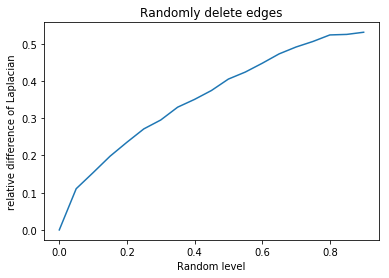

In [143]:
plt.plot(random_level, L_dif_1)
plt.ylabel('relative difference of Laplacian')
plt.xlabel('Random level')
plt.title('Randomly delete edges')
plt.show()

In [144]:
G_dif_1[0,0]

0.0

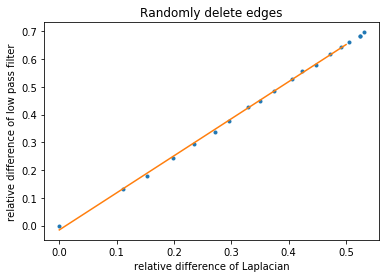

In [145]:
xp = np.linspace(0, 0.5, 100)
p1 = np.poly1d(np.polyfit(L_dif_1, G_dif_1[:,0], 1))
plt.plot(L_dif_1, G_dif_1[:,0], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of low pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly delete edges')
plt.show()

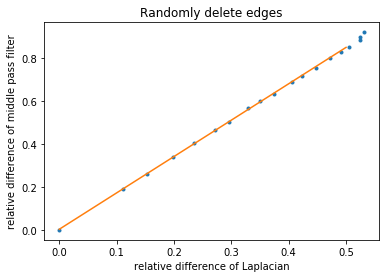

In [146]:
xp = np.linspace(0, 0.5, 100)
p1 = np.poly1d(np.polyfit(L_dif_1, G_dif_1[:,1], 1))
plt.plot(L_dif_1, G_dif_1[:,1], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of middle pass filter')
plt.xlabel('relative difference of Laplacian')

plt.title('Randomly delete edges')
plt.show()

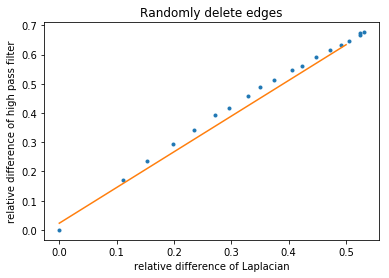

In [147]:
xp = np.linspace(0, 0.5, 100)
p1 = np.poly1d(np.polyfit(L_dif_1, G_dif_1[:,2], 1))
plt.plot(L_dif_1, G_dif_1[:,2], '.', xp, p1(xp)-0.02, '-')

plt.ylabel('relative difference of high pass filter')

plt.xlabel('relative difference of Laplacian')
plt.title('Randomly delete edges')
plt.show()

In [129]:
##########################
###                    ###
###   PERTURBATION 2   ###
###                    ###
##########################


def add_random_edges(A, k):
    """This function adds fraction k of graph edges."""
    
    if k<0:
        print("k must be positive.")
        return
    
    if k>1:
        print("k must be <=1.")
        return
    
    if k==0:
        A_tilde = sp.csr_matrix(A, dtype=np.float32)
        A_tilde.eliminate_zeros()
        print("k = ", k, " -> Adding 0 edges out of ", A_tilde.nnz // 2, ".")
        return A_tilde
    
    if k==1:
        M, M = A.shape
        A_tilde = np.ones((M,M))
        A_tilde = sp.csr_matrix(A_tilde, dtype=np.float32)
        A_tilde.eliminate_zeros()
        print("k = ", k, " -> Adding all missing edges.")
        return A_tilde
    
    
    A_csr = sp.csr_matrix(A, dtype=np.float32)
    A_csr.setdiag(0)
    A_csr.eliminate_zeros()
    
    A_coo = sp.triu(A_csr, format='coo') 
    A_coo.eliminate_zeros()
    
    
    if k<1:
        M, M = A.shape

        mask = np.triu(np.ones((M,M)), k=1) # k=1 means that non-zeros are only above main diagonal
        mask_coo = sp.coo_matrix(mask)     
        mask_coo = mask_coo - A_coo    
        mask_coo.eliminate_zeros()
        #print(mask_coo) #.toarray().astype(int)
        
        missing_edges = mask_coo.nnz
        add_edges = int(round(k * 5278))
        
        print("k = ", k, " -> Adding ", add_edges, " edges out of ", missing_edges, " missing.")
         
        zeros = np.zeros(add_edges)
        ones = np.ones(missing_edges - add_edges)
        filter_mask = np.random.permutation(np.concatenate((zeros, ones), axis=0))
        
        mask_coo.data = mask_coo.data - filter_mask
        mask_coo.eliminate_zeros()
        
        A_augmented_coo = A_coo + mask_coo
        
        A_output = A_augmented_coo + A_augmented_coo.transpose()
        
        #print(A_output.toarray().astype(int))     
   
        A_output = A_output.tocsr() 
        A_output.setdiag(0)
        A_output.eliminate_zeros()    
           
        return A_output

In [130]:
# Generate random weight matrix NxN

# Generate random weight matrix NxN
A, _, _, _, _, _ = process_data.load_data("cora")
N, _ = A.shape
print("Matrix size = ", A.shape, " Number of edges = ", scipy.sparse.csr_matrix(A, dtype=np.float32).nnz // 2, "\n")


# Convert generated matrix into csr format
A_csr = scipy.sparse.csr_matrix(A, dtype=np.float32)

# Compute Laplacian of original matrix B
laplacian_A_csr = graph.laplacian(A_csr, normalized=True)

# Normalization factor
norm_factor = np.linalg.norm(laplacian_A_csr.toarray(), 'fro')
# Scale 
#h_1 = h * 2.0 / norm_factor
h_2 = h

(2708, 2708)
(2708, 1433)
Matrix size =  (2708, 2708)  Number of edges =  5278 



In [131]:
random_level = np.arange(0, 0.95, 0.05)
L_dif_2 = []
G_dif_2 = []
t_start = time.time()
low_a = cayley_operator(laplacian_A_csr.toarray(), 12, 2.0, coefficients_low)
middle_a = cayley_operator(laplacian_A_csr.toarray(), 12, 1.0, coefficients_middle)
high_a = cayley_operator(laplacian_A_csr.toarray(), 12, 1.1, coefficients_high)
for level in random_level:
    A_prime = add_random_edges(A, level)
    L_prime = graph.laplacian(A_prime, normalized=True)
    L_dif_2.append(np.linalg.norm(laplacian_A_csr.toarray() - L_prime.toarray(), 'fro') / norm_factor)
    low_b = cayley_operator(L_prime.toarray(), 12, 2.0, coefficients_low)
    middle_b = cayley_operator(L_prime.toarray(), 12, 1.0, coefficients_middle)
    high_b = cayley_operator(L_prime.toarray(), 12, 1.1, coefficients_high)
    G_dif_2.append([np.linalg.norm(low_a-low_b,'fro')/norm_factor, np.linalg.norm(middle_a-middle_b,'fro')/norm_factor, np.linalg.norm(high_a-high_b,'fro')/norm_factor])  
G_dif_2 = np.array(G_dif_2)    
print('Execution time: {:.2f}s'.format(time.time() - t_start))

k =  0.0  -> Adding 0 edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.05  -> Adding  264  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.1  -> Adding  528  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.15000000000000002  -> Adding  792  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.2  -> Adding  1056  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.25  -> Adding  1320  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.30000000000000004  -> Adding  1583  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.35000000000000003  -> Adding  1847  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.4  -> Adding  2111  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.45  -> Adding  2375  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.5  -> Adding  2639  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.55  -> Adding  2903  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.6000000000000001  -> Adding  3167  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.65  -> Adding  3431  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.7000000000000001  -> Adding  3695  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.75  -> Adding  3958  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8  -> Adding  4222  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8500000000000001  -> Adding  4486  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.9  -> Adding  4750  edges out of  3660000  missing.
Execution time: 1458.38s


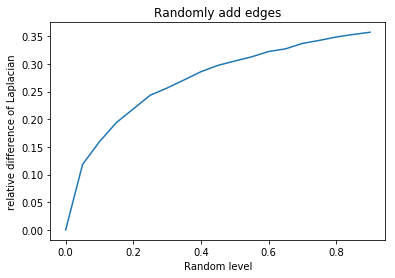

In [132]:
plt.plot(random_level, L_dif_2)
plt.ylabel('relative difference of Laplacian')
plt.xlabel('Random level')
plt.title('Randomly add edges')
plt.show()

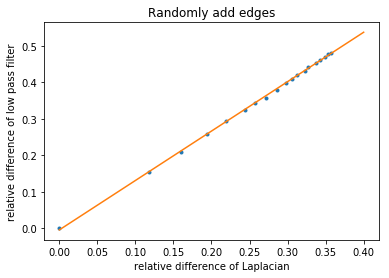

In [133]:
xp = np.linspace(0, .4, 100)
p1 = np.poly1d(np.polyfit(L_dif_2, G_dif_2[:,0], 1))
plt.plot(L_dif_2, G_dif_2[:,0], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of low pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly add edges')
plt.show()

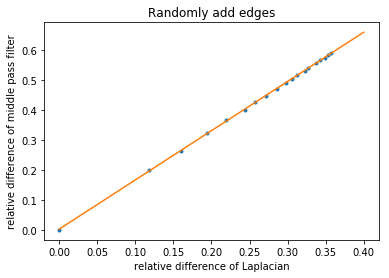

In [134]:
xp = np.linspace(0, .4, 100)
p1 = np.poly1d(np.polyfit(L_dif_2, G_dif_2[:,1], 1))
plt.plot(L_dif_2, G_dif_2[:,1], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of middle pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly add edges')
plt.show()

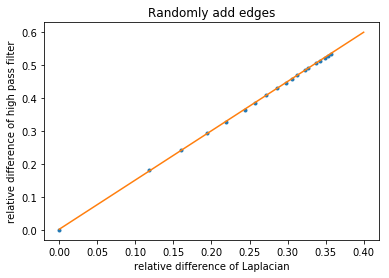

In [135]:
xp = np.linspace(0, .4, 100)
p1 = np.poly1d(np.polyfit(L_dif_2, G_dif_2[:,2], 1))
plt.plot(L_dif_2, G_dif_2[:,2], '.', xp, p1(xp), '-')
plt.ylabel('relative difference of high pass filter')
plt.xlabel('relative difference of Laplacian')
plt.title('Randomly add edges')
plt.show()

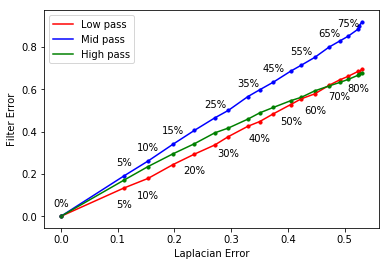

In [2]:
#############
### LATEX ###
#############
L_dif_1 = np.loadtxt('l_dif_1.txt')
L_dif_2 = np.loadtxt('l_dif_2.txt')
G_dif_1 = np.loadtxt('g_dif_1.txt')
G_dif_2 = np.loadtxt('g_dif_2.txt')
L_dif_1 = np.asarray(L_dif_1)
L_dif_2 = np.asarray(L_dif_2)
G_dif_1 = np.asarray(G_dif_1)
G_dif_2 = np.asarray(G_dif_2)

plt.plot(L_dif_1, G_dif_1[:,0], 'r')
plt.scatter(L_dif_1, G_dif_1[:,0], c='r', s=10)


plt.plot(L_dif_1, G_dif_1[:,1], 'b')
plt.scatter(L_dif_1, G_dif_1[:,1], c='b', s=10)


plt.plot(L_dif_1, G_dif_1[:,2], 'g')
plt.scatter(L_dif_1, G_dif_1[:,2], c='g', s=10)




labels = ["0%", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%", "55%", "60%", "65%", "70%", "75%", "80%", "85%", "90%"]

i=0
for x,y in zip(L_dif_1, G_dif_1[:,1]):
    
    label = labels[i]
    i = i+1
    
    if i in [0, 1, 2, 3, 4, 6, 8, 10, 12, 14, 16]:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


i=0
for x,y in zip(L_dif_1, G_dif_1[:,0]):
    
    label = labels[i]
    i = i+1
    
    if i in [2, 3, 5, 7, 9, 11, 13, 15, 17]:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-20), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


legend = ["Low pass", "Mid pass", "High pass"]

plt.ylabel('Filter Error')
plt.xlabel('Laplacian Error')
plt.legend(legend)
#plt.title('(a)')
plt.savefig("./linear_stability_1.pdf", format='pdf')
plt.show()


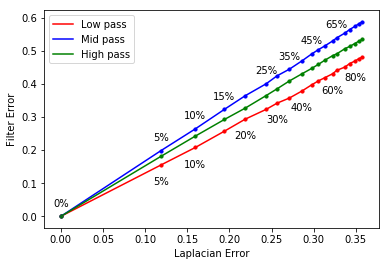

In [3]:
#############
### LATEX ###
#############

plt.plot(L_dif_2, G_dif_2[:,0], 'r')
plt.scatter(L_dif_2, G_dif_2[:,0], c='r', s=10)


plt.plot(L_dif_2, G_dif_2[:,1], 'b')
plt.scatter(L_dif_2, G_dif_2[:,1], c='b', s=10)


plt.plot(L_dif_2, G_dif_2[:,2], 'g')
plt.scatter(L_dif_2, G_dif_2[:,2], c='g', s=10)


labels = ["0%", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%", "55%", "60%", "65%", "70%", "75%", "80%", "85%", "90%"]

i=0
for x,y in zip(L_dif_2, G_dif_2[:,1]):
    
    label = labels[i]
    i = i+1
    
    if i in [0, 1, 2, 3, 4, 6, 8, 10, 14]:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


i=0
for x,y in zip(L_dif_2, G_dif_2[:,0]):
    
    label = labels[i]
    i = i+1
    
    if i in [2, 3, 5, 7, 9, 13, 17]:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-20), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center




legend = ["Low pass", "Mid pass", "High pass"]

plt.ylabel('Filter Error')
plt.xlabel('Laplacian Error')
plt.legend(legend)
#plt.title('(b)')
plt.savefig("./linear_stability_2.pdf", format='pdf')
plt.show()


In [150]:
L_dif_1 = np.array(L_dif_1)
L_dif_2 = np.array(L_dif_2)
G_dif_1 = np.array(G_dif_1)
G_dif_2 = np.array(G_dif_2)
np.savetxt('l_dif_1.txt', L_dif_1)
np.savetxt('l_dif_2.txt', L_dif_2)
np.savetxt('g_dif_1.txt', G_dif_1)
np.savetxt('g_dif_2.txt', G_dif_2)

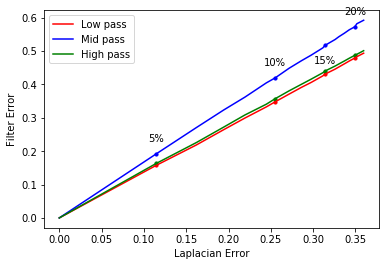

In [46]:
#############
### LATEX ###
#############
L_dif_1 = np.loadtxt('l_dif_1.txt')
L_dif_2 = np.loadtxt('l_dif_2.txt')
G_dif_1 = np.loadtxt('g_dif_1.txt')
G_dif_2 = np.loadtxt('g_dif_2.txt')
L_dif_1 = np.asarray(L_dif_1)
L_dif_2 = np.asarray(L_dif_2)
G_dif_1 = np.asarray(G_dif_1)
G_dif_2 = np.asarray(G_dif_2)

xp = np.linspace(0, 0.5, 100)
p1 = np.poly1d(np.polyfit(L_dif_1, G_dif_1[:,0], 1))


L_dif_2 = np.asarray(L_dif_2)


plt.plot(L_dif_2, G_dif_2[:,0], 'r')
plt.scatter(L_dif_2[1::5], G_dif_2[1::5,0], c='r', s=10)


plt.plot(L_dif_2, G_dif_2[:,1], 'b')
plt.scatter(L_dif_2[1::5], G_dif_2[1::5,1], c='b', s=10)


plt.plot(L_dif_2, G_dif_2[:,2], 'g')
plt.scatter(L_dif_2[1::5], G_dif_2[1::5,2], c='g', s=10)


labels = ["5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%", "55%", "60%", "65%", "70%", "75%", "80%", "85%", "90%"]

i=0
for x,y in zip(L_dif_2[1::5], G_dif_2[1::5,1]):

    label = labels[i]
    i = i+1

    if i in [0, 1, 2, 4, 6, 8, 10, 14]:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,12), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        

i=0      
for x,y in zip(L_dif_2[1::5], G_dif_2[1::5,0]):

    label = labels[i]
    i = i+1

    if i in [3, 5, 7, 9, 13, 17]:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center




legend = ["Low pass", "Mid pass", "High pass"]

plt.ylabel('Filter Error')
plt.xlabel('Laplacian Error')
plt.legend(legend)
#plt.title('(b)')
plt.savefig("./linear_stability_2.pdf", format='pdf')
plt.show()

In [27]:
def cayley_operator(A, r, coefficients):
    AA = np.eye(A.shape[0])
    res = np.zeros_like(A)
    for k in range(r):
        res = res + 2.0* coefficients[k+1] * (AA @ A).real
        AA = AA @ A
    return res.real  

In [25]:
random_level = np.arange(0, 0.95, 0.05)
L_dif_1 = []
G_dif_1 = []
t_start = time.time()
a = (h_1*laplacian_A_csr.toarray() - 1j*np.identity(N)) @ np.linalg.inv(h_1*laplacian_A_csr.toarray() + 1j*np.identity(N))
low_a = cayley_operator(a, r, coefficients_low)
middle_a = cayley_operator(a, r, coefficients_middle)
high_a = cayley_operator(a, r, coefficients_high)
for level in random_level:
    A_prime = remove_random_edges(A, level)
    L_prime = graph.laplacian(A_prime, normalized=True)
    L_dif_1.append(np.linalg.norm(laplacian_A_csr.toarray() - L_prime.toarray(), 'fro') / norm_factor)
    b = (h_1*L_prime.toarray() - 1j*np.identity(N))@ np.linalg.inv(h_1*L_prime.toarray() + 1j*np.identity(N))
    low_b = cayley_operator(b, r, coefficients_low)
    middle_b = cayley_operator(b, r, coefficients_middle)
    high_b = cayley_operator(b, r, coefficients_high)
    G_dif_1.append([np.linalg.norm(low_a-low_b,'fro')/norm_factor, np.linalg.norm(middle_a-middle_b,'fro')/norm_factor, np.linalg.norm(high_a-high_b,'fro')/norm_factor])  
G_dif_1 = np.array(G_dif_1)    
print('Execution time: {:.2f}s'.format(time.time() - t_start))

TypeError: cayley_operator() missing 1 required positional argument: 'coefficients'

In [37]:
random_level = np.arange(0, 0.95, 0.05)
L_dif_2 = []
G_dif_2 = []
t_start = time.time()
a = (h_2*laplacian_A_csr.toarray() - 1j*np.identity(N)) @ np.linalg.inv(h_2*laplacian_A_csr.toarray() + 1j*np.identity(N))
low_a = cayley_operator(a, r, coefficients_low)
middle_a = cayley_operator(a, r, coefficients_middle)
high_a = cayley_operator(a, r, coefficients_high)
for level in random_level:
    A_prime = add_random_edges(A, level)
    L_prime = graph.laplacian(A_prime, normalized=True)
    L_dif_2.append(np.linalg.norm(laplacian_A_csr.toarray() - L_prime.toarray(), 'fro') / norm_factor)
    b = (h_2*L_prime.toarray() - 1j*np.identity(N))@ np.linalg.inv(h_2*L_prime.toarray() + 1j*np.identity(N))
    low_b = cayley_operator(b, r, coefficients_low)
    middle_b = cayley_operator(b, r, coefficients_middle)
    high_b = cayley_operator(b, r, coefficients_high)
    G_dif_2.append([np.linalg.norm(low_a-low_b,'fro')/norm_factor, np.linalg.norm(middle_a-middle_b,'fro')/norm_factor, np.linalg.norm(high_a-high_b,'fro')/norm_factor])  
G_dif_2 = np.array(G_dif_2)    
print('Execution time: {:.2f}s'.format(time.time() - t_start))

k =  0.0  -> Adding 0 edges out of  5278 .


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.05  -> Adding  264  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.1  -> Adding  528  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.15000000000000002  -> Adding  792  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.2  -> Adding  1056  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.25  -> Adding  1320  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.30000000000000004  -> Adding  1583  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.35000000000000003  -> Adding  1847  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.4  -> Adding  2111  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.45  -> Adding  2375  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.5  -> Adding  2639  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.55  -> Adding  2903  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.6000000000000001  -> Adding  3167  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.65  -> Adding  3431  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.7000000000000001  -> Adding  3695  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.75  -> Adding  3958  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8  -> Adding  4222  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.8500000000000001  -> Adding  4486  edges out of  3660000  missing.


/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


k =  0.9  -> Adding  4750  edges out of  3660000  missing.
Execution time: 1242.02s
